![delensalot logo](./../../res/dlensalot2.PNG)

# Interactive minimal working example - data access - full sky
In this notebook, you access your own data; maps, alms, or cls. Depending on what you provide, `delensalot` will either use them 'as is', generate noise on top of it, lens the data, or synthesize realisations from the provided power spectra.

This all comes with a very hand interface and only a couple of parameter, which we will explore in the following.

The `delensalot` model-object responisible for handling the data is `DLENSALOT_Simulation` and we will make heavy use of it.

In [11]:
from IPython.display import clear_output
from datetime import datetime
import os
from os.path import join as opj
if "SCRATCH" not in os.environ:
    # By default, data will be stored right at the current working directory. However, this may not be a safe place, so perhaps choose something else
    os.environ["SCRATCH"] = "./SCRATCH/delensalot/tutorial_data"
    # os.environ["SCRATCH"] = "/mnt/c/Users/sebas/OneDrive/SCRATCH"

from IPython.display import clear_output
from datetime import datetime

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import join as opj

import delensalot
from delensalot.run import run
from delensalot.utility.utils_hp import gauss_beam
from delensalot.config.metamodel.dlensalot_mm import DLENSALOT_Model, DLENSALOT_Analysis, DLENSALOT_Data, DLENSALOT_Simulation


from delensalot.config.visitor import transform, transform3d
from delensalot.core.opfilt.opfilt_handler import QE_transformer, MAP_transformer
from delensalot.config.transformer.lerepi2dlensalot import l2delensalotjob_Transformer, l2T_Transformer
from delensalot.config.metamodel.dlensalot_mm import DLENSALOT_Model, DLENSALOT_Analysis
from delensalot.core.iterator.iteration_handler import iterator_transformer

beam = 1.
nlev_p = np.sqrt(10)
nside = 1024
lmax = 3*nside
transfunction = gauss_beam(beam/180/60 * np.pi, lmax=lmax)

### Prerequisite: generate example data
Before we can access data, we will need some. You can use `sim_lib` to generate them.

## Check mapspace

In [12]:
from delensalot.sims.sims_lib import Xunl, Xsky, Xobs

synunl = Xunl(lmax=lmax, nside=nside)
QUunl = synunl.get_sim_unl(0, spin=2, space='map', field='polarization')
EBunl = synunl.get_sim_unl(0, spin=0, space='map', field='polarization')
phi = synunl.get_sim_phi(0, space='map')
phi *= 1
synunl.cacher.cache('phi_space{}_{}'.format('map', 0), phi)

synsky = Xsky(nside=nside, lmax=lmax, unl_lib=synunl)

QUsky = synsky.get_sim_sky(0, spin=2, space='map', field='polarization')
EBsky = synsky.get_sim_sky(0, spin=0, space='map', field='polarization')

synobs = Xobs(nside=nside, lmax=lmax, len_lib=synsky, transfunction=transfunction, nlev_p=nlev_p)
QUobs = synobs.get_sim_obs(0, spin=2, space='map', field='polarization')
EBobs = synobs.get_sim_obs(0, spin=0, space='map', field='polarization')

EBnoise = synobs.get_sim_noise(0, spin=0, space='map', field='polarization')
QUnoise = synobs.get_sim_noise(0, spin=2, space='map', field='polarization')

space = 'map'

Text(0, 0.5, '$D_\\ell$')

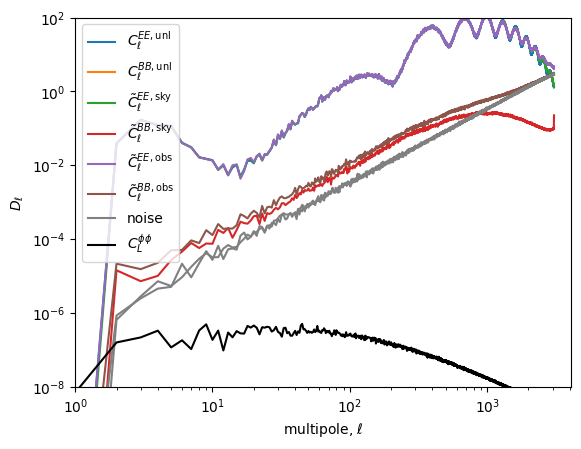

In [13]:
ll = np.arange(0,lmax+1,1)
LL = np.arange(0,np.min([3*nside,lmax+1024+1]),1)
scale_factor_l = (ll*(ll+1))/np.sqrt(2*np.pi)
scale_factor_L = (LL*(LL+1))**2/np.sqrt(2*np.pi)

plt.plot(scale_factor_l * hp.anafast(EBunl[0], lmax=lmax), label=r'$C_\ell^{EE, \rm{unl}}$')
plt.plot(scale_factor_l * hp.anafast(EBunl[1], lmax=lmax), label=r'$C_\ell^{BB, \rm{unl}}$')

plt.plot(scale_factor_l * hp.anafast(EBsky[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{sky}}$')
plt.plot(scale_factor_l * hp.anafast(EBsky[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{sky}}$')

plt.plot(scale_factor_l * hp.anafast(EBobs[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$')
plt.plot(scale_factor_l * hp.anafast(EBobs[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$')

plt.plot(scale_factor_l * hp.anafast(EBnoise[0], lmax=lmax), label='noise', color='grey')
plt.plot(scale_factor_l * hp.anafast(EBnoise[1], lmax=lmax), color='grey')

plt.plot(scale_factor_L * hp.anafast(phi), color='black', label=r'$C_L^{\phi\phi}$')

plt.legend()
plt.xlim(1,lmax+1024)
plt.ylim(1e-8,1e2)

plt.loglog()
plt.xlabel(r'multipole, $\ell$')
plt.ylabel(r'$D_\ell$')

## Check almspace

In [14]:
from delensalot.sims.sims_lib import Xunl, Xsky, Xobs

synunl = Xunl(lmax=lmax)
EBunl = synunl.get_sim_unl(0, spin=0, space='alm', field='polarization')
phi = synunl.get_sim_phi(0, space='alm')
phi *= 1
synunl.cacher.cache('phi_space{}_{}'.format('alm', 0), phi)

synsky = Xsky(nside=nside, lmax=lmax, unl_lib=synunl)
EBsky = synsky.get_sim_sky(0, spin=0, space='alm', field='polarization')

synobs = Xobs(nside=nside, lmax=lmax, len_lib=synsky, transfunction=transfunction, nlev_p=nlev_p)
EBobs = synobs.get_sim_obs(0, spin=0, space='alm', field='polarization')
EBnoise = synobs.get_sim_noise(0, spin=0, space='alm', field='polarization')


space = 'alm'

Text(0, 0.5, '$D_\\ell$')

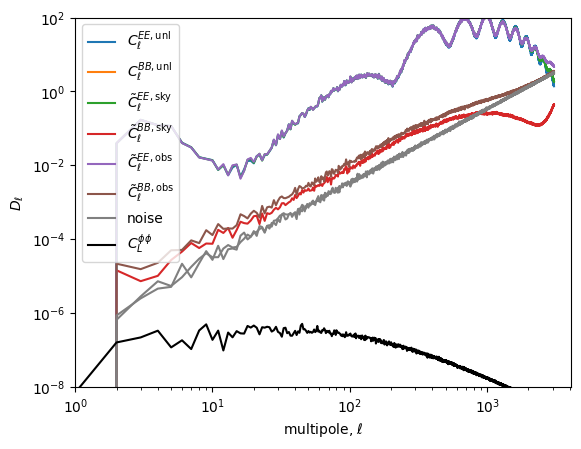

In [15]:
ll = np.arange(0,lmax+1,1)
LL = np.arange(0,lmax+1024+1,1)
scale_factor_l = (ll*(ll+1))/np.sqrt(2*np.pi)
scale_factor_L = (LL*(LL+1))**2/np.sqrt(2*np.pi)

plt.plot(scale_factor_l * hp.alm2cl(EBunl[0], lmax=lmax), label=r'$C_\ell^{EE, \rm{unl}}$')
plt.plot(scale_factor_l * hp.alm2cl(EBunl[1], lmax=lmax), label=r'$C_\ell^{BB, \rm{unl}}$')

plt.plot(scale_factor_l * hp.alm2cl(EBsky[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{sky}}$')
plt.plot(scale_factor_l * hp.alm2cl(EBsky[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{sky}}$')

plt.plot(scale_factor_l * hp.alm2cl(EBobs[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$')
plt.plot(scale_factor_l * hp.alm2cl(EBobs[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$')

plt.plot(scale_factor_l * hp.alm2cl(EBnoise[0], lmax=lmax), label='noise', color='grey')
plt.plot(scale_factor_l * hp.alm2cl(EBnoise[1], lmax=lmax), color='grey')

plt.plot(scale_factor_L * hp.alm2cl(phi), color='black', label=r'$C_L^{\phi\phi}$')

plt.legend()
plt.xlim(1,lmax+1024)
plt.ylim(1e-8,1e2)

plt.loglog()
plt.xlabel(r'multipole, $\ell$')
plt.ylabel(r'$D_\ell$')

### Check lenspyx lensing

Text(0, 0.5, '$D_\\ell$')

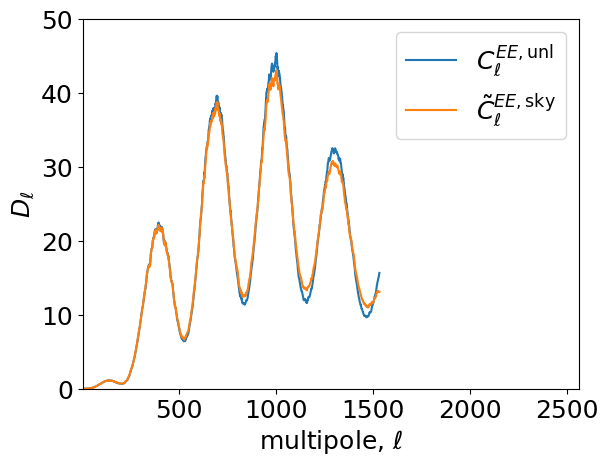

In [6]:
from delensalot.utility.plot_helper import movavg

ll = np.arange(0,lmax+1,1)
scale_factor_l = (ll*(ll+1))/(2*np.pi)


plt.plot(movavg(scale_factor_l * hp.alm2cl(EBunl[0], lmax=lmax), 8), label=r'$C_\ell^{EE, \rm{unl}}$')
plt.plot(movavg(scale_factor_l * hp.alm2cl(EBsky[0], lmax=lmax) , 8), label=r'$\tilde{C}_\ell^{EE, \rm{sky}}$')

plt.legend()
plt.xlim(1,lmax+1024)
plt.ylim(0,0.5e2)

# plt.loglog()
plt.xlabel(r'multipole, $\ell$')
plt.ylabel(r'$D_\ell$')

/tmp/ipykernel_31140/2134112627.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(movavg((hp.alm2cl(EBsky[0], lmax=lmax)-hp.alm2cl(EBunl[0], lmax=lmax))/hp.alm2cl(EBunl[0], lmax=lmax), 8))


(0.0, 3000.0)

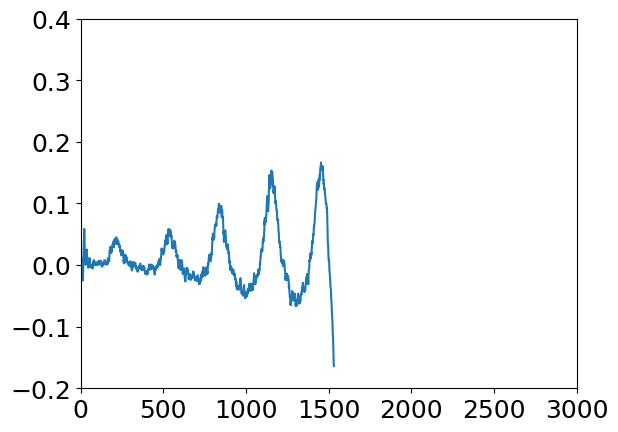

In [7]:
plt.plot(movavg((hp.alm2cl(EBsky[0], lmax=lmax)-hp.alm2cl(EBunl[0], lmax=lmax))/hp.alm2cl(EBunl[0], lmax=lmax), 8))
plt.ylim(-0.2,0.4)
plt.xlim(0, 3000)

Once you are happy with the data, store them as follows:
 * for each flavour (unl, sky, obs), make a directory
 * for each component (noise, cmb, phi), store the map and alms in that directory

In [11]:
paths = {'unl': opj(os.environ["SCRATCH"], 'unl/'), 'sky': opj(os.environ["SCRATCH"], 'sky/'), 'obs': opj(os.environ["SCRATCH"], 'obs/')}
files = {
    0: {
        'unl': EBunl, 'sky': EBsky, 'obs': EBobs},
    2: {
        'sky': QUsky, 'obs': QUobs
    }}

for flavour in ['unl', 'sky', 'obs']:
    if not os.path.exists(paths[flavour]):
        os.makedirs(paths[flavour])

for simidx in [0]:
    for flavour in ['unl', 'sky', 'obs']:
        for spin in [2]:
            if space == 'map':
                if flavour != 'unl':
                    fnQ = opj(paths[flavour], 'Q{}{}_{:05d}.npy'.format(space, flavour, simidx))
                    fnU = opj(paths[flavour], 'U{}{}_{:05d}.npy'.format(space, flavour, simidx))
                    np.save(fnQ, files[spin][flavour][0])
                    np.save(fnU, files[spin][flavour][1])

                if flavour == 'sky':
                    fnQ = opj(paths[flavour], 'Q{}noise_{:05d}.npy'.format(space, simidx))
                    fnU = opj(paths[flavour], 'U{}noise_{:05d}.npy'.format(space, simidx))
                    np.save(fnQ, QUnoise[0])
                    np.save(fnU, QUnoise[1])
        for spin in [0]:
            fnE = opj(paths[flavour], 'E{}{}_{:05d}.npy'.format(space, flavour, simidx))
            fnB = opj(paths[flavour], 'B{}{}_{:05d}.npy'.format(space, flavour, simidx))
            np.save(fnE, files[spin][flavour][0])
            np.save(fnB, files[spin][flavour][1])
            if flavour == 'sky':
                fnE = opj(paths[flavour], 'E{}noise_{:05d}.npy'.format(space, simidx))
                fnB = opj(paths[flavour], 'B{}noise_{:05d}.npy'.format(space, simidx))
                np.save(fnE, EBnoise[0])
                np.save(fnB, EBnoise[1])
            if flavour == 'unl':
                fnphi = opj(paths[flavour], 'phi{}_{:05d}.npy'.format(space, simidx))
                np.save(fnphi, phi)

We now have toy data.

## Case 1: observed or component separated maps (e.g. CMB-S4)
in our first example, imagine you are given observed (or component separated) maps. This is the optimal case for `delensalot`, as nothing needs to be done other than providing the data to it. You may have them as EB or QU maps, and `delensalot` can work with both.

All you have to do is configure a `DLENSALOT_Simulation` with the correct values.

In [2]:
paths = {'unl': opj(os.environ["SCRATCH"], 'unl/'), 'sky': opj(os.environ["SCRATCH"], 'sky/'), 'obs': opj(os.environ["SCRATCH"], 'obs/')}
space = 'alm'
flavour = 'obs'
lmax = lmax
nside = nside
beam = beam
lib_dir = paths['obs']
fns = ['Q{space}obs_{{:05d}}.npy'.format(space=space), 'U{space}obs_{{:05d}}.npy'.format(space=space)]

# dm_spin2 = DLENSALOT_Model(
#     simulationdata = DLENSALOT_Simulation(
#         space = space, 
#         flavour = flavour,
#         lmax = lmax,
#         nside = nside,
#         lib_dir = lib_dir,
#         fns = fns,
#         spin = 2
# ))

fns = ['E{space}obs_{{:05d}}.npy'.format(space=space), 'B{space}obs_{{:05d}}.npy'.format(space=space)]
dm_spin0 = DLENSALOT_Model(
    simulationdata = DLENSALOT_Simulation(
        space = space, 
        flavour = flavour,
        lmax = lmax,
        nside = nside,
        lib_dir = lib_dir,
        fns = fns,
        spin = 0
))

That's it, in principle. This delensalot model will use the simulation as you provided them. Convince yourself by creating a QE lensrec job model `jm`. You can find the provided data via `jm.simulation` 

In [3]:
job_id = 'QE_lensrec'
# jm2 = transform3d(dm_spin2, job_id, l2delensalotjob_Transformer())
# EBobs_fromspin2 = jm2.simulationdata.get_sim_obs(0, spin=0, space='map', field='polarization')

jm0 = transform3d(dm_spin0, job_id, l2delensalotjob_Transformer())
EBobs_fromspin0 = jm0.simulationdata.get_sim_obs(0, spin=0, space='map', field='polarization')

/mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/plancklens/plancklens/utils.py:124: RuntimeWarning: overflow encountered in cast
  return hashlib.sha1(np.copy(cl.astype(dtype), order='C')).hexdigest()


Text(0, 0.5, '$D_\\ell$')

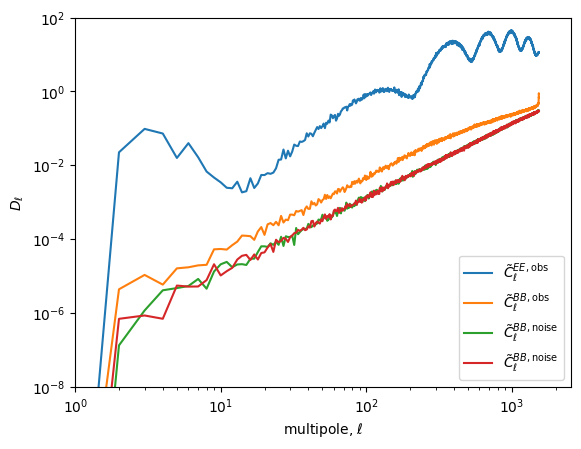

In [5]:
ll = np.arange(0,lmax+1,1)
scale_factor_l = (ll*(ll+1))/(2*np.pi)

plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$')
# plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin2[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$', ls='--')

plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$')
# plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin2[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$', ls='--')
plt.plot(scale_factor_l * hp.anafast(EBnoise[0], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{noise}}$')
plt.plot(scale_factor_l * hp.anafast(EBnoise[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{noise}}$')
plt.legend()
plt.xlim(1,lmax+1024)
plt.ylim(1e-8,1e2)

plt.loglog()
plt.xlabel(r'multipole, $\ell$')
plt.ylabel(r'$D_\ell$')

Text(0, 0.5, '$D_\\ell$')

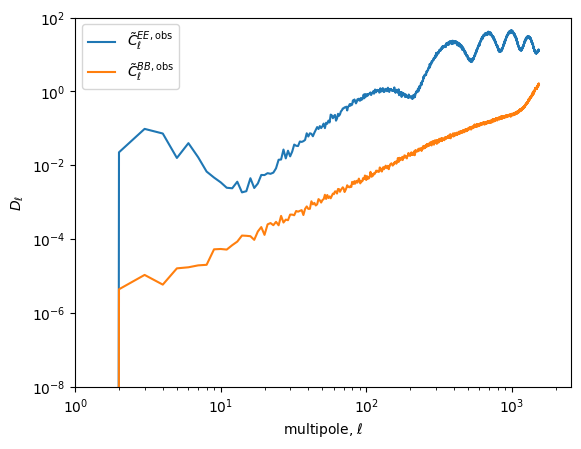

In [7]:
job_id = 'QE_lensrec'
# jm2 = transform3d(dm_spin2, job_id, l2delensalotjob_Transformer())
# EBobs_fromspin2 = jm2.simulationdata.get_sim_obs(0, spin=0, space='alm', field='polarization')

jm0 = transform3d(dm_spin0, job_id, l2delensalotjob_Transformer())
EBobs_fromspin0 = jm0.simulationdata.get_sim_obs(0, spin=0, space='alm', field='polarization')



ll = np.arange(0,lmax+1,1)
scale_factor_l = (ll*(ll+1))/(2*np.pi)

plt.plot(scale_factor_l * hp.alm2cl(EBobs_fromspin0[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$')
# plt.plot(scale_factor_l * hp.alm2cl(EBobs_fromspin2[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$', ls='--')

plt.plot(scale_factor_l * hp.alm2cl(EBobs_fromspin0[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$')
# plt.plot(scale_factor_l * hp.alm2cl(EBobs_fromspin2[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$', ls='--')

plt.legend()
plt.xlim(1,lmax+1024)
plt.ylim(1e-8,1e2)

plt.loglog()
plt.xlabel(r'multipole, $\ell$')
plt.ylabel(r'$D_\ell$')

If you want to delens the data, 
 * simply `run()` one of the models `dm_spin0` or `dm_spin2`, or,
 * take on of the delensalot job models `jm0` or `jm2`, and collect and run their computing jobs 

In [ ]:
mode = 'I prefer the delensalot.run()'
mode = 'I prefer the job model'
if mode == 'I prefer the delensalot.run()':
    from delensalot.run import run
    runner = run(config_model=dm_spin2, job_id='MAP_lensrec')
elif mode == 'I prefer the job model':
    jm2.collect_jobs()
    jm2.run()

## Case 2 A: sky maps - generate noise ::: (e.g. millDL)
Imagine you are given sky maps (likely from a simulation suite) and noise levels of the experiment.

In this case, `delensalot` has generate the observed data and noise first, which it can.

All you need to do is configure a `DLENSALOT_Simulation` with the correct values.
 * sky maps
 * noise generator
 * transfer function

In [8]:
paths = {'unl': opj(os.environ["SCRATCH"], 'unl/'), 'sky': opj(os.environ["SCRATCH"], 'sky/'), 'obs': opj(os.environ["SCRATCH"], 'obs/')}
space = 'map'
flavour = 'sky'
lmax = lmax
nside = nside
lib_dir = paths['sky']
transfunction = gauss_beam(beam/180/60 * np.pi, lmax=lmax)
nlev_p = np.sqrt(10)/4


fns = ['Esky_{:05d}.npy', 'Bsky_{:05d}.npy']
dm_spin0 = DLENSALOT_Model(
    simulationdata = DLENSALOT_Simulation(
        space = space, 
        flavour = flavour,
        lmax = lmax,
        nside = nside,
        lib_dir = lib_dir,
        transfunction = transfunction,
        fns = fns, 
        nlev_p = nlev_p, 
        spin = 0
))

fns = ['Qsky_{:05d}.npy', 'Usky_{:05d}.npy']
dm_spin2 = DLENSALOT_Model(
    simulationdata = DLENSALOT_Simulation(
        space = space, 
        flavour = flavour,
        lmax = lmax,
        nside = nside,
        lib_dir = lib_dir,
        transfunction = transfunction,
        fns = fns,
        nlev_p = nlev_p, 
        spin = 2
))

In [9]:
job_id = 'QE_lensrec'
jm0 = transform3d(dm_spin0, job_id, l2delensalotjob_Transformer())
EBobs_fromspin0 = jm0.simulationdata.get_sim_pmap(0, spin=0)

jm2 = transform3d(dm_spin2, job_id, l2delensalotjob_Transformer())
EBobs_fromspin2 = jm2.simulationdata.get_sim_pmap(0, spin=0)

Text(0, 0.5, '$D_\\ell$')

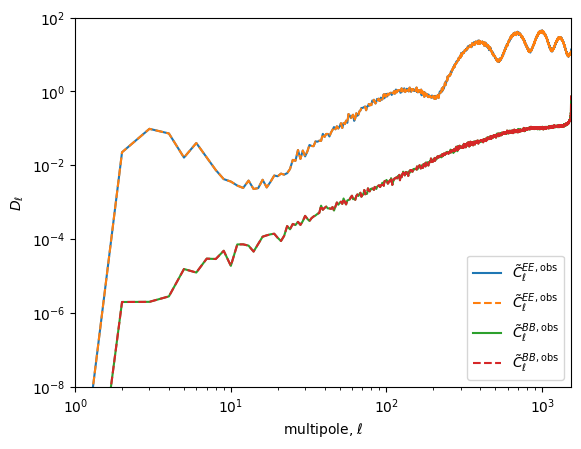

In [10]:
ll = np.arange(0,lmax+1,1)
scale_factor_l = (ll*(ll+1))/(2*np.pi)

plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$')
plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin2[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$', ls='--')

plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$')
plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin2[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$', ls='--')

plt.legend()
plt.xlim(1,lmax)
plt.ylim(1e-8,1e2)

plt.loglog()
plt.xlabel(r'multipole, $\ell$')
plt.ylabel(r'$D_\ell$')

## Case 2 B: sky maps and noise maps
in our next example, imagine you are given sky maps (likely from a simulation suite). You are also given noise maps.
Both sky and noise may come as EB or QU, delensalot can handle it.

In this case, you will have to generate the observed data yourself.
No worries, `delensalot` has you covered.

All we need to do is configure a `DLENSALOT_Simulation` with the correct values.
 * sky maps
 * noise maps
 * transfer function

In [4]:
paths = {'unl': opj(os.environ["SCRATCH"], 'unl/'), 'sky': opj(os.environ["SCRATCH"], 'sky/'), 'obs': opj(os.environ["SCRATCH"], 'obs/')}
space = 'map'
flavour = 'sky'
lmax = lmax
nside = nside
lib_dir = paths['sky']
lib_dir_noise = paths['sky']
transfunction = gauss_beam(beam/180/60 * np.pi, lmax=lmax)


fns = ['E{space}sky_{{:05d}}.npy'.format(space=space), 'B{space}sky_{{:05d}}.npy'.format(space=space)]
fnsnoise = ['E{space}noise_{{:05d}}.npy'.format(space=space), 'B{space}noise_{{:05d}}.npy'.format(space=space)]
dm_spin0 = DLENSALOT_Model(
    simulationdata = DLENSALOT_Simulation(
        space = space, 
        flavour = flavour,
        lmax = lmax,
        nside = nside,
        lib_dir = lib_dir,
        lib_dir_noise = lib_dir_noise,
        transfunction = transfunction,
        fns = fns, 
        fnsnoise = fnsnoise,
        spin = 0
))

fns = ['Q{space}sky_{{:05d}}.npy'.format(space=space), 'U{space}sky_{{:05d}}.npy'.format(space=space)]
fnsnoise = ['Q{space}noise_{{:05d}}.npy'.format(space=space), 'U{space}noise_{{:05d}}.npy'.format(space=space)]
dm_spin2 = DLENSALOT_Model(
    simulationdata = DLENSALOT_Simulation(
        space = space, 
        flavour = flavour,
        lmax = lmax,
        nside = nside,
        lib_dir = lib_dir,
        lib_dir_noise = lib_dir_noise,
        transfunction = transfunction,
        fns = fns,
        fnsnoise = fnsnoise,
        spin = 2
))

In [5]:
job_id = 'QE_lensrec'
jm0 = transform3d(dm_spin0, job_id, l2delensalotjob_Transformer())
EBobs_fromspin0 = jm0.simulationdata.get_sim_obs(0, spin=0, space='map', field='polarization')

jm2 = transform3d(dm_spin2, job_id, l2delensalotjob_Transformer())
EBobs_fromspin2 = jm2.simulationdata.get_sim_obs(0, spin=0, space='map', field='polarization')

Text(0, 0.5, '$D_\\ell$')

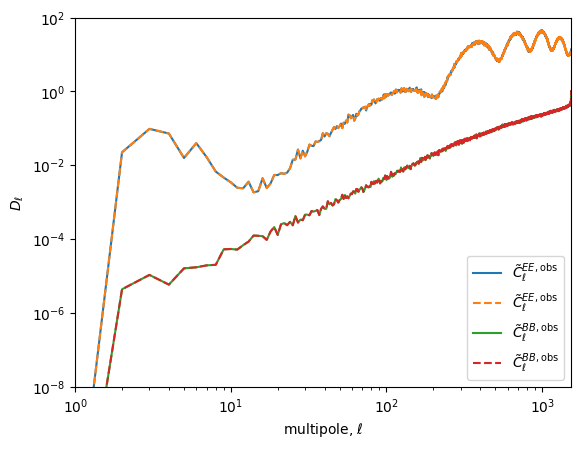

In [6]:
ll = np.arange(0,lmax+1,1)
scale_factor_l = (ll*(ll+1))/(2*np.pi)

plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$')
plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin2[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$', ls='--')

plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$')
plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin2[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$', ls='--')

plt.legend()
plt.xlim(1,lmax)
plt.ylim(1e-8,1e2)

plt.loglog()
plt.xlabel(r'multipole, $\ell$')
plt.ylabel(r'$D_\ell$')

## Case 3: Ulensed alms, and philm ::: (e.g. N32)
Imagine you are given unlensed alms, philms, and noise levels of the experiment.

In this case, you will have to lens your data first, then generate the observed data and noise.
No worries, `delensalot` has you covered, and thanks to `lenspyx`, it is also very fast!

All we need to do is configure a `DLENSALOT_Simulation` with the correct values.
 * unlensed alms
 * noise generator
 * phi alm
 * transfer function

In [10]:
paths = {'unl': opj(os.environ["SCRATCH"], 'unl/'), 'sky': opj(os.environ["SCRATCH"], 'sky/'), 'obs': opj(os.environ["SCRATCH"], 'obs/')}
space = 'alm'
flavour = 'unl'
lmax = lmax
nside = nside
lib_dir = paths['unl']
transfunction = gauss_beam(beam/180/60 * np.pi, lmax=lmax)
nlev_p = np.sqrt(10)/4
fns = ['E{space}unl_{{:05d}}.npy'.format(space=space), 'B{space}unl_{{:05d}}.npy'.format(space=space)]

lib_dir_phi = paths['unl']
fnsP = 'phi{space}_{{:05d}}.npy'.format(space=space)
phi_space = 'alm'
phi_field = 'potential'

dm_spin0 = DLENSALOT_Model(
    simulationdata = DLENSALOT_Simulation(
        space = space, 
        flavour = flavour,
        lmax = lmax,
        nside = nside,
        lib_dir = lib_dir,
        lib_dir_phi = lib_dir_phi,
        transfunction = transfunction,
        fns = fns,
        fnsP = fnsP,  
        nlev_p = nlev_p,
        phi_field = phi_field,
        phi_space = phi_space,
))

In [11]:
job_id = 'QE_lensrec'
jm0 = transform3d(dm_spin0, job_id, l2delensalotjob_Transformer())
EBobs_fromspin0 = jm0.simulationdata.get_sim_obs(0, spin=0, space='map', field='polarization')

Text(0, 0.5, '$D_\\ell$')

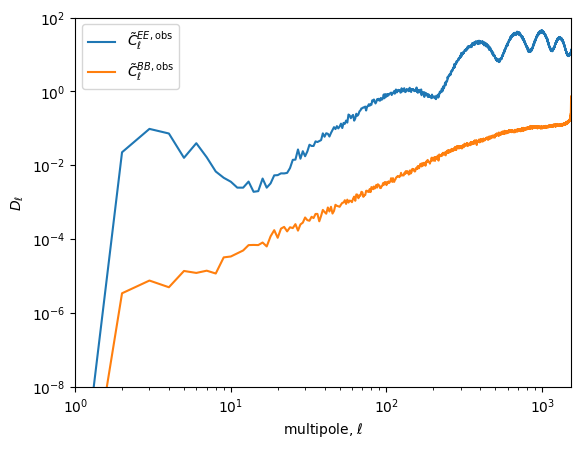

In [12]:
ll = np.arange(0,lmax+1,1)
scale_factor_l = (ll*(ll+1))/(2*np.pi)

plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$')

plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$')

plt.legend()
plt.xlim(1,lmax)
plt.ylim(1e-8,1e2)

plt.loglog()
plt.xlabel(r'multipole, $\ell$')
plt.ylabel(r'$D_\ell$')

## Case 4 A: Cls and clphi ::: (e.g. N32)
Imagine you are given a CAMB-like file with CMB power spectra, and another file with the phi power spectrum, and noise levels of the experiment.

In this case, you will have to synthesize, then lens, then generate the observed data and noise.
No worries, `delensalot` has you covered, and thanks to `lenspyx`, it is also very fast!

All we need to do is configure a `DLENSALOT_Simulation` with the correct values.
 * unlensed alms
 * noise generator
 * phi alm
 * transfer function

In [6]:
paths = {'unl': opj(os.environ["SCRATCH"], 'unl/'), 'sky': opj(os.environ["SCRATCH"], 'sky/'), 'obs': opj(os.environ["SCRATCH"], 'obs/')}
space = 'cl'
flavour = 'unl'
lmax = lmax
nside = nside
CAMB_fn = opj(os.path.dirname(delensalot.__file__), 'data', 'cls', 'FFP10_wdipole_lenspotentialCls.dat')
clphi_fn = opj(os.path.dirname(delensalot.__file__), 'data', 'cls', 'FFP10_wdipole_lenspotentialCls.dat')
transfunction = gauss_beam(beam/180/60 * np.pi, lmax=lmax)
nlev_p = np.sqrt(10)/4
phi_field = 'potential'

dm_spin0 = DLENSALOT_Model(
    simulationdata = DLENSALOT_Simulation(
        space = space, 
        flavour = flavour,
        lmax = lmax,
        nside = nside,
        transfunction = transfunction,
        nlev_p = nlev_p,
        phi_field = phi_field,
        clphi_fn = clphi_fn,
))

In [7]:
job_id = 'QE_lensrec'
jm0 = transform3d(dm_spin0, job_id, l2delensalotjob_Transformer())
EBobs_fromspin0 = jm0.simulationdata.get_sim_obs(0, spin=0, space='map', field='polarization')

Text(0, 0.5, '$D_\\ell$')

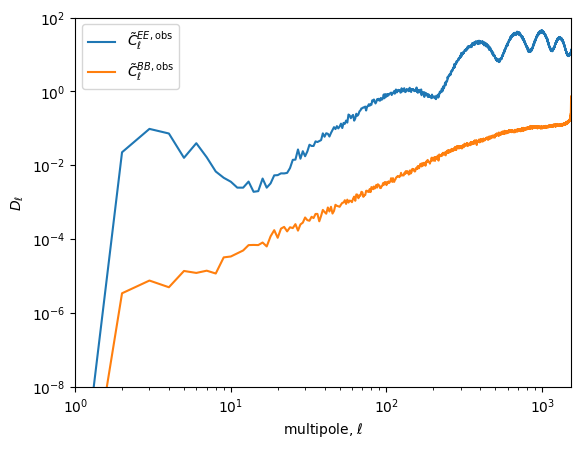

In [8]:
ll = np.arange(0,lmax+1,1)
scale_factor_l = (ll*(ll+1))/(2*np.pi)

plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$')

plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$')

plt.legend()
plt.xlim(1,lmax)
plt.ylim(1e-8,1e2)

plt.loglog()
plt.xlabel(r'multipole, $\ell$')
plt.ylabel(r'$D_\ell$')

## Case 4 B: Cls and phi (alm or map) ::: (e.g. N32)
Imagine you are given a CAMB-like file with CMB power spectra, and another file with the phi realization, and noise levels of the experiment.

In this case, you will have to synthesize, then lens, then generate the observed data and noise.
No worries, `delensalot` has you covered, and thanks to `lenspyx`, it is also very fast!

All we need to do is configure a `DLENSALOT_Simulation` with the correct values.
 * unlensed alms
 * noise generator
 * phi alm
 * transfer function

In [19]:
paths = {'unl': opj(os.environ["SCRATCH"], 'unl/'), 'sky': opj(os.environ["SCRATCH"], 'sky/'), 'obs': opj(os.environ["SCRATCH"], 'obs/')}
space = 'cl'
flavour = 'unl'
lmax = lmax
nside = nside
CAMB_fn = opj(os.path.dirname(delensalot.__file__), 'data', 'cls', 'FFP10_wdipole_lenspotentialCls.dat')

clphi_fn = 'None'
phi_space = 'alm'
fnsP = 'phi{space}_{{:05d}}.npy'.format(space=phi_space)
phi_field = 'potential'
lib_dir_phi = paths['unl']

transfunction = gauss_beam(beam/180/60 * np.pi, lmax=lmax)
nlev_p = np.sqrt(10)/4


dm_spin0_philm = DLENSALOT_Model(
    simulationdata = DLENSALOT_Simulation(
        space = space, 
        flavour = flavour,
        lmax = lmax,
        nside = nside,
        transfunction = transfunction,
        nlev_p = nlev_p,
        phi_field = phi_field,
        clphi_fn = clphi_fn,
        lib_dir_phi = lib_dir_phi,
        fnsP = fnsP,
        phi_space = phi_space,
))

phi_space = 'map'
fnsP = 'phi{space}_{{:05d}}.npy'.format(space=phi_space)

dm_spin0_phimap = DLENSALOT_Model(
    simulationdata = DLENSALOT_Simulation(
        space = space, 
        flavour = flavour,
        lmax = lmax,
        nside = nside,
        transfunction = transfunction,
        nlev_p = nlev_p,
        phi_field = phi_field,
        clphi_fn = clphi_fn,
        lib_dir_phi = lib_dir_phi,
        fnsP = fnsP,
        phi_space = phi_space,
))

In [20]:
job_id = 'QE_lensrec'
jm0_philm = transform3d(dm_spin0_philm, job_id, l2delensalotjob_Transformer())
EBobs_fromspin0philm = jm0_philm.simulationdata.get_sim_obs(0, spin=0, space='map', field='polarization')

jm0_phimap = transform3d(dm_spin0_phimap, job_id, l2delensalotjob_Transformer())
EBobs_fromspin0phimap = jm0_philm.simulationdata.get_sim_obs(0, spin=0, space='map', field='polarization')

/mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/plancklens/plancklens/utils.py:124: RuntimeWarning: overflow encountered in cast
  return hashlib.sha1(np.copy(cl.astype(dtype), order='C')).hexdigest()


Text(0, 0.5, '$D_\\ell$')

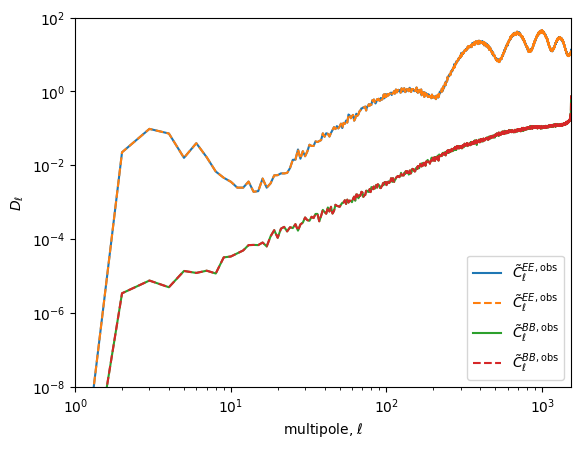

In [21]:
ll = np.arange(0,lmax+1,1)
scale_factor_l = (ll*(ll+1))/(2*np.pi)

plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0philm[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$')
plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0phimap[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$', ls='--')

plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0philm[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$')
plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0phimap[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$', ls='--')

plt.legend()
plt.xlim(1,lmax)
plt.ylim(1e-8,1e2)

plt.loglog()
plt.xlabel(r'multipole, $\ell$')
plt.ylabel(r'$D_\ell$')

This concludes the tutorial. If you'd like to see how to delens the data you have, go check out [this notebook](https://github.com/NextGenCMB/delensalot/blob/main/notebooks/examples/interactive_mwe.py).

# Summary and next steps
This tutorial demonstrated how to generate lensed simulation data.

To learn how to use `delensalot` for lensing reconstruction and more, check out the other tutorials, or see the [documentation](link_to_rtd_doc), or [github](https://github.com/NextGenCMB/delensalot).